In [0]:
import torch

if torch.cuda.is_available(): import torch.cuda as t
else: import torch as t
  
from torch import nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import math, random

import matplotlib.pyplot as plt

#### Globals

In [0]:
PLOT_GRAPHS = True
DEBUG_PRINT = True
VERBOSE_RATE = 25

### Hyperparameters

In [0]:
#similar parameters to the comp paper
# PHONEME_INVENTORY_SIZE = 16 + 1
# VOCABULARY_SIZE = 48

# SENTINEL_ID = PHONEME_INVENTORY_SIZE - 1
# MAX_WORD_LENGTH = 4
# PHONEMES = range(PHONEME_INVENTORY_SIZE-1) #exclude sentinel

# input_size = PHONEME_INVENTORY_SIZE
# embed_size = PHONEME_INVENTORY_SIZE
# hidden_size = 256
# goal_size = VOCABULARY_SIZE
# n_layers = 1 #EncoderLSTM
# dropout = 0.1
# learning_rate = 1e-3


PHONEME_INVENTORY_SIZE = 4 + 1
VOCABULARY_SIZE = 10

SENTINEL_ID = PHONEME_INVENTORY_SIZE - 1
MAX_WORD_LENGTH = 4
PHONEMES = range(PHONEME_INVENTORY_SIZE-1) #exclude sentinel

input_size = PHONEME_INVENTORY_SIZE
embed_size = PHONEME_INVENTORY_SIZE
hidden_size = 256
goal_size = VOCABULARY_SIZE
n_layers = 1 #EncoderLSTM
dropout = 0.1
learning_rate = 1e-3

batch_size = 10 #training
GUMBEL_TAU = 0.5

MAX_SEQLEN = 100

### Helper Fns

In [0]:
#Helper functions

def one_hot(integers, k):
  to_return = t.FloatTensor(len(integers),k).fill_(0)
  to_return[range(len(integers)), integers] = 1
  return to_return

def idx_one_hot(one_hots, dim = 1):
  '''
  :param one_hots:
    batch 1 hots in shape of [B,K]
  '''
  
  return [i.item() for i in torch.argmax(one_hots, dim)]


def generate_random_word():
    length = random.choice(range(1, MAX_WORD_LENGTH+1))
    word = [random.choice(PHONEMES) for _ in range(length)]
    return word

def generate_random_vocabulary():
    words = [generate_random_word() for _ in range(VOCABULARY_SIZE)]
    return {i:word for i, word in enumerate(words)}

def agent_seq_prob(meaning, target, speaker):
  prob = 1.
  for t_step in range(len(target)):
    so_far = target[:t_step,:,:] #[t,B,P]
    target_a = torch.argmax(target[t_step,0])
    a_distro = speaker(so_far, meaning) #[B,P] probability distribution of phonemes
    prob *= a_distro[0,target_a] 

  return prob

def utterance_to_feats(utterance, size): #currently B = 1
  utterance_feats = t.FloatTensor().view(0,1,size)
  for a in utterance:
    utterance_feats = torch.cat((utterance_feats,one_hot([a],size).unsqueeze(0)))
  return utterance_feats
  

### Attention RNN Model

In [0]:
class AttentionRNN(nn.Module):
  '''
  Seq -> [LSTM] -> Context (+ goal) -> [AttnNN] -> AttentionContext (+ goal)-> [DecoderNN] -> Softmax Distribution
  
  For agent: seq so far + goal --> action distribution
  For listener: seq from agent --> goal distribution
  '''
  
  def __init__(self,  lstm_input_size, embed_size, hidden_size,
                      decoder_layer_dims, decoder_activation_fn, 
                      goal_input_size = 0,
                      lstm_layers=1, lstm_dropout=0.5, lstm_bidirectional = True):
    '''
    :input_size:
      sequence element vector length (for agent, each element is a phoneme, so input_size would be PHONEME_SIZE)
    :embed_size:
      i set it equal to input_size
    :hidden_size:
      vector length for hidden state
    '''
    super(AttentionRNN, self).__init__()
    self.hidden_size = hidden_size
    self.goal_input_size = goal_input_size
    self.input_size = lstm_input_size
    
    ''' SEQ ENCODER (LSTM)'''
    self.embedding = nn.Linear(lstm_input_size, embed_size, bias = False)
    self.lstm = nn.LSTM(embed_size, hidden_size, lstm_layers, dropout=dropout, bidirectional=lstm_bidirectional)
    
    ''' ATTN NN '''
    self.attn = nn.Linear(self.hidden_size + goal_input_size, hidden_size)
    self.v = nn.Parameter(t.FloatTensor(hidden_size).uniform_(0,1))
    stdv = 1. / math.sqrt(self.v.size(0))
    self.v.data.normal_(mean=0, std=stdv)
    
    ''' CONTEXT DECODER NN'''
    decoder_layer_dims[0] += goal_input_size
    self.hidden_layers = nn.ModuleList([nn.Linear(decoder_layer_dims[i],decoder_layer_dims[i+1]) for i in range(len(decoder_layer_dims)-1)])
    self.activation_fn = decoder_activation_fn

    
        
  def forward(self, input_seq, goal = None):
    
    
    ''' SEQ ENCODER '''
    if(len(input_seq) == 0):
      encoder_outputs = t.FloatTensor(1,input_seq.shape[1], self.hidden_size).fill_(0) #initial h0
    else:
      embedded = self.embedding(input_seq) #[T,B,E]
      encoder_outputs, _ = self.lstm(embedded, None) #outputs : (T, B, (2*)H)
      encoder_outputs = encoder_outputs[:, :, :self.hidden_size] + encoder_outputs[:, :, self.hidden_size:]  # Sum bidirectional outputs

    
    ''' ATTN NN '''
    max_len = encoder_outputs.size(0)
    this_batch_size = encoder_outputs.size(1)
    encoder_outputs = encoder_outputs.transpose(0,1) # [B*T*H]
    
    if(self.goal_input_size != 0): #g:(B,G)
      goal_expanded = goal.float().repeat(encoder_outputs.shape[1],1,1).transpose(1,0) #(B,G) => (T,B,G) => (B,T,G)
      inp = torch.cat((encoder_outputs, goal_expanded),2) #[B,T,H] <concat> [B,T,G] ==> [B,T,(H+G)]
    else:
      inp = encoder_outputs
    energy = self.attn(inp)
    energy = energy.transpose(2,1) # [B*H*T]
    v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) #[B*1*H]
    energy = torch.bmm(v, energy) # [B*1*T]
    attn_energies = energy.squeeze(1) #[B*T]
    
    
    ''' CONTEXT DECODER '''
    attn_weights = F.softmax(attn_energies, dim = 1).unsqueeze(1) # normalize with softmax #[B,1,T] 
    context = attn_weights.bmm(encoder_outputs)  # [B,1,T].bmm([B,T,H]) ==> (B,1,H)
    context = context.transpose(0, 1).squeeze(0)  # (B,H)

    if(self.goal_input_size != 0): #g:(B,G)
      inp = torch.cat((context, goal),1) #(B,H+G)
    else:
      inp = context
      
    x = self.activation_fn(self.hidden_layers[0](inp))
    for i in range(1,len(self.hidden_layers)-1):
      x = self.activation_fn(self.hidden_layers[i](x))
    x = self.hidden_layers[-1](x)

    return F.softmax(x, dim = 1) #[B,P] -- distro for each batch item

### agent_generate_utterance()

In [0]:
# Have the agent forward-sample a sequence
def agent_generate_utterance(meaning, speaker, use_gumbel_softmax = True, include_sentinel = False):
  '''
  :meaning:
    in shape of [B = 1, G] (one-hot)
  '''
  so_far = t.FloatTensor().view(0,1,speaker.input_size)
  
  total_ent = t.FloatTensor().view(0,1)
  
  max_seq_length = MAX_SEQLEN
  
  while True:
    #input_seq = so_far.long().unsqueeze(1) #[t] ==> [t,1]
      
    #encoder
    a_distro = speaker(so_far, meaning) #[B,P]
    ent = (-a_distro * torch.log(a_distro.squeeze(0))).sum(dim = 1)
    
    #NOTE:
    #this will cause speaker to minimize p(eos) and produce infinitely long utterances if ent_reg
    #even if you manually average entropy
    #total_ent += ent 
    total_ent = torch.cat((total_ent, ent.unsqueeze(0)))
    
    
    #sample from a_distro
    if(use_gumbel_softmax):
      sampled_a = F.gumbel_softmax(a_distro, tau = GUMBEL_TAU, hard = True)#[B,P]
    else:
      sampled_a = one_hot(torch.distributions.Categorical(a_distro).sample(), speaker.input_size) #[B=1,P]
    
    
    #update so_far
    if torch.argmax(sampled_a, dim = 1)[0] == SENTINEL_ID:
      if(include_sentinel):
        so_far = torch.cat((so_far,sampled_a.unsqueeze(0))) 
      break
    else:
      so_far = torch.cat((so_far,sampled_a.unsqueeze(0))) #update sequences
    
    if(len(so_far) >= max_seq_length):
      print(f"WARNING: Utterance > {max_seq_length}")
      if(include_sentinel):
        so_far = torch.cat((so_far,one_hot([SENTINEL_ID],speaker.input_size).view(1,1,-1))) 
      break
      
#   if DEBUG_PRINT: print(len(so_far))
  return so_far, total_ent.mean(dim = 0)

### train_joint()

In [0]:
def train_joint(meanings, speaker, listener, opt, batch_size, num_epochs, ent_reg_value = 0.01, ent_regularization = False):

  graph_plots = []
  verbose_rate = VERBOSE_RATE
  
  pos = 0
    
  avg_nll_loss = 0.0
  avg_ent = 0.0
  utt_len = 0.0
  
  for epoch in range(1, num_epochs+1):
    loss = 0.0
    
    random.shuffle(meanings)

    for i in range(batch_size):
      i%=len(meanings)
      
      #sample utterance from agent u~A(g)
      g = one_hot([meanings[i]], len(meanings))
      utterance,ent = agent_generate_utterance(g, speaker)
      utt_len += len(utterance)
      
      #listener predict p(g|u)
      g_distro = listener(utterance) #[B = 1, G]

      #loss
      nll = -torch.log(g_distro)[0][meanings[i]]
      avg_ent += float(ent.item())
      ent = ent_reg_value*ent
      loss += nll - ent
      avg_nll_loss += float(nll.item())


    #update gradients
    loss /= batch_size
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if (epoch % 25 == 0):
      epoch_loss = avg_nll_loss/(verbose_rate*batch_size)
      epoch_ent = avg_ent/(verbose_rate*batch_size)
      
      acc = eval_exp(meanings,speaker,listener).values()
      acc_num = round(sum(acc)/len(acc),4)
      if (epoch % verbose_rate == 0): 
        print(f"Epoch {epoch}, acc: {acc_num}, avg nll loss: {round(epoch_loss,4)}, avg ent: {round(epoch_ent,4)}, avg utterance length: {utt_len/(verbose_rate*batch_size)}")
        print(f"\taccuracy (Total): {acc_num}, (Indi): {acc}\n")
   
      #save for graph
      if(PLOT_GRAPHS): 
        graph_plots.append((epoch, acc_num, epoch_loss, epoch_ent))

      avg_nll_loss = 0.0
      avg_ent = 0.0
      utt_len = 0.0
  
  return graph_plots

### train_joint_rl()

In [0]:
def speaker_loss(meaning_1h, tgt_utterance_feats, speaker):
  loss = 0.0
  total_ent = t.FloatTensor().view(0,1)
  loss = t.FloatTensor(len(tgt_utterance_feats)).fill_(0)
  for i in range(len(tgt_utterance_feats)): #sequence length including sentinel
    
    a_distro = speaker(tgt_utterance_feats[:i], meaning_1h)
    target_a = torch.argmax(tgt_utterance_feats[i].squeeze(0))
    
    ent = (-a_distro * torch.log(a_distro.squeeze(0))).sum(dim = 1)
    total_ent = torch.cat((total_ent, ent.unsqueeze(0)))
    
    loss[i] = -torch.log(a_distro[0][target_a])
  return loss.mean(), total_ent.mean(dim = 0)

def listener_loss(utterance_feats, tgt_meaning, listener):
  g_distro = listener(utterance_feats)
  return -torch.log(g_distro[0][tgt_meaning])
    

In [0]:
def train_joint_rl(meanings, speaker, listener, opt, batch_size, num_epochs, ent_reg_value = 0.01):
  '''
  [1] run 1 simulation step:
        i.    sample utterance from speaker given goal
        ii.   sample predicted goal from listener given speaker's utterance

  [2] define reward:
        i.    1 if matching goals else 0
        ii.   is there a softer reward function? a proxy reward function?
  
  [3] define loss
        i.    obtain NLL loss (using a_distro) for speaker given sampled utterance (target)
        ii.   obtain NLL loss (using g_distro) for listener given sampled predicted goal (target)
        iii.  sum the separate reward-scale NLL loss for speaker and listener
        iv.   add low-entropy loss (to maximize entropy)
        (v).  subtract baseline from reward
        
  '''
  graph_plots = []
  verbose_rate = VERBOSE_RATE
  
  epoch_loss = 0.0
  epoch_ent = 0.0
  utt_len = 0.0
  
  meanings = list(meanings)
  
  acc = eval_exp(meanings,speaker,listener).values()
  print(f"\taccuracy ({sum(acc)/len(acc)}): {acc}")
    
  for epoch in range(1, n_epochs+1):
    random.shuffle(meanings)
    loss = 0.0
    batch_ent = 0.0
    
    for i in range(batch_size):
      i%=len(meanings)
      meaning = meanings[i]
      meaning_1h = one_hot([meaning], len(meanings))

      #[1] run sim
      with torch.no_grad():
        sampled_utterance, _ = agent_generate_utterance(meaning_1h, speaker, use_gumbel_softmax = False, include_sentinel = True) #should we use gumbel for sim?
        g_distro = listener(sampled_utterance[:-1])
        sampled_g = torch.distributions.Categorical(g_distro).sample().squeeze(0)
        #sampled_g_1h = one_hot(torch.distributions.Categorical(g_distro).sample(), len(meanings)) #[B=1,P]
        utt_len += len(sampled_utterance[:-1])

      #[2] define reward
      reward = 1 if sampled_g == meaning else 0

      #[3] loss
      speaker_l, ent = speaker_loss(meaning_1h, sampled_utterance, speaker)
      listener_l = listener_loss(sampled_utterance[:-1], meaning, listener)
      loss += ((speaker_l + listener_l) * reward) - (ent_reg_value*ent)
      batch_ent += ent.item()
      
    #[4] backprop
    loss /= batch_size
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    epoch_loss += loss.item()
    epoch_ent += batch_ent/batch_size
    if (epoch % 25 == 0):
      epoch_loss = round(epoch_loss/verbose_rate,4)
      epoch_ent = round(epoch_ent/verbose_rate,4)
      acc = eval_exp(meanings,speaker,listener).values()
      acc_num = round(sum(acc)/len(acc),4)
      if (epoch % verbose_rate == 0):
        print(f"Epoch {epoch}, loss: {epoch_loss}, speaker ent: {epoch_ent}, avg u length: {utt_len/(verbose_rate*batch_size)}")
        print(f"\taccuracy (Total): {acc_num}, (Indi): {acc}\n")
      
      #save for graph
      if(PLOT_GRAPHS): graph_plots.append((epoch,acc_num, epoch_loss,epoch_ent))
        
      epoch_loss = 0.0
      epoch_ent = 0.0
      utt_len = 0.0
      
  return graph_plots
  

### train_speaker()

In [0]:

def score_speaker(meaning, target, speaker):
  '''
  Cross-entropy loss
  
  :meaning:
    in shape of [B = 1, G] (one-hot)
  :target:
    in shape of [T,B,P] (msg_feats)
    
  '''
  loss = t.FloatTensor(len(target)).fill_(0)
  for i in range(len(target)):
    a_distro = speaker(target[:i], meaning)
    target_a = torch.argmax(target[i].squeeze(0))
    loss[i] =  -torch.log(a_distro[0,target_a]) #cross-entropy loss
  return loss.mean()


    
def train_speaker(vocab, speaker, opt, batch_size, n_epochs):
  '''
  :vocab:
    {goal:utterance}
  '''
  graph_plots = []
  
  vocab_list = list(vocab.items())
  n_vocab = len(vocab_list)
  
  for e in range(1,n_epochs+1):
    loss = 0.0
    
    random.shuffle(vocab_list)
    mini_batch = vocab_list[:batch_size]

    for i in range(batch_size):
      g, target_utterance = mini_batch[i%len(mini_batch)]
      g = one_hot([g],n_vocab) 
      target_utterance = utterance_to_feats(target_utterance+[SENTINEL_ID], speaker.input_size)
      loss += score_speaker(g, target_utterance, speaker)

    loss /= batch_size
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if(e%25 == 0): 
      print(f"epoch {e}: loss {loss.item()}")
      if(PLOT_GRAPHS): graph_plots.append((e,loss.item()))

  print(f"epoch {e}: loss {loss.item()}")
  
  return graph_plots

### train_listener()

In [0]:
def score_listener(utterance, target, listener):
  '''
  :utterance:
    in shape of [T,B,P] (msg_feats)
  :target:
    goal id (int)
  '''
  loss = 0.0
  g_distro = listener(utterance)
  return -torch.log(g_distro)[0][target] #cross-entropy loss

def train_listener(vocab, listener, opt, batch_size, n_epochs):
  '''
  :vocab:
    {goal:utterance}
  '''
  graph_plots = []
  vocab_list = list(vocab.items())
  n_vocab = len(vocab_list)
  
  for e in range(1,n_epochs+1):
    loss = 0.0
    
    random.shuffle(vocab_list)
    mini_batch = vocab_list[:batch_size]

    for i in range(batch_size):
      target_g, utterance = mini_batch[i%len(mini_batch)]
      utterance = utterance_to_feats(utterance, listener.input_size)
      loss += score_listener(utterance, target_g, listener)

    loss /= batch_size
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if(e%25 == 0): 
      print(f"epoch {e}: loss {loss.item()}")
      if(PLOT_GRAPHS): graph_plots.append((e,loss.item()))
        
  print(f"epoch {e}: loss {loss.item()}")
  return graph_plots

### eval()

In [0]:
def eval_exp(meanings, speaker, listener, n_trials = 100):
  with torch.no_grad():
    meaning_accs = {}
    for meaning in meanings:
      g = one_hot([meaning], len(meanings))
      acc = 0.0
      for i in range(n_trials):
        
        #if we don't use gumbel, it gets stuck??
        utterance,_ = agent_generate_utterance(g, speaker, use_gumbel_softmax = True) 
        
        #listener predict p(g|u)
        #pred_g = torch.argmax(listener(utterance).squeeze(0)) #[B = 1, G]
        pred_g = torch.distributions.Categorical(listener(utterance).squeeze(0)).sample()
        
        acc += int(pred_g == meaning)
      acc /= n_trials
      meaning_accs[meaning] = acc
  return meaning_accs

def eval_speaker(vocab, speaker):
  corrects = []
  incorrects = []
  for g in vocab:
    g_1h = one_hot([g], len(vocab))
    utterance_feats,_ = agent_generate_utterance(g_1h, speaker, use_gumbel_softmax = False, include_sentinel = True)
    produced = torch.argmax(utterance_feats.squeeze(1), dim = 1)
    if(len(vocab[g]+[SENTINEL_ID]) == len(produced) and torch.all(torch.eq(t.FloatTensor(vocab[g]+[SENTINEL_ID]),produced.float()))):
      corrects.append( (g, vocab[g]+[SENTINEL_ID], produced) )
    else:
      incorrects.append( (g, vocab[g]+[SENTINEL_ID], produced) )
    
  return corrects, incorrects

def eval_listener(vocab, listener):
  corrects = []
  incorrects = []
  
  for g in vocab:
    utterance = utterance_to_feats(vocab[g],listener.input_size)
    g_distro = listener(utterance).squeeze(0)
    sampled_g = torch.distributions.Categorical(g_distro).sample()
    if(g == sampled_g):
      corrects.append( (g, sampled_g, g_distro[g], vocab[g]) )
    else:
      incorrects.append( (g, sampled_g, g_distro[g], vocab[g]) )
  return corrects, incorrects


### Agent initializations

In [0]:
# speaker = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
#                      decoder_layer_dims = [hidden_size,hidden_size,PHONEME_INVENTORY_SIZE], decoder_activation_fn = torch.tanh, 
#                      goal_input_size = goal_size,
#                      lstm_layers=1, lstm_dropout=0.5, lstm_bidirectional = True).to(device)

# listener = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
#                      decoder_layer_dims = [hidden_size,hidden_size,VOCABULARY_SIZE], decoder_activation_fn = torch.tanh, 
#                      goal_input_size = 0,
#                      lstm_layers=1, lstm_dropout=0.5, lstm_bidirectional = True).to(device)

# params = list(speaker.parameters()) + list(listener.parameters())
# optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)


### Run (Sanity Tests)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(Before) Acurracy: 0.0
epoch 25: loss 1.846883773803711
epoch 50: loss 1.2737830877304077
epoch 75: loss 0.6299797892570496
epoch 100: loss 0.31220191717147827
epoch 125: loss 0.1722346544265747
epoch 150: loss 0.10636670887470245
epoch 175: loss 0.07166726142168045
epoch 200: loss 0.051571089774370193
epoch 225: loss 0.03903583437204361
epoch 250: loss 0.030699705705046654
epoch 275: loss 0.024887023493647575
epoch 300: loss 0.020670581609010696
epoch 325: loss 0.017506716772913933
epoch 350: loss 0.015065639279782772
epoch 375: loss 0.013139274902641773
epoch 400: loss 0.011591004207730293
epoch 425: loss 0.010327683761715889
epoch 450: loss 0.009282978251576424
epoch 475: loss 0.0084083778783679
epoch 500: loss 0.007667699363082647
epoch 500: loss 0.007667699363082647
(After) Acurracy: 1.0


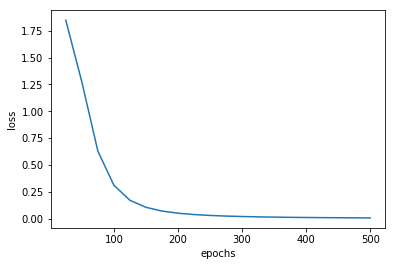

In [34]:
'''
Train speaker only
'''
speaker = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                     decoder_layer_dims = [hidden_size,hidden_size,PHONEME_INVENTORY_SIZE], decoder_activation_fn = torch.tanh, 
                     goal_input_size = goal_size,
                     lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

params = list(speaker.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)

vocab = generate_random_vocabulary()

n_epochs = 500

corrects, incorrects = eval_speaker(vocab, speaker)
print(f"(Before) Acurracy: {len(corrects)/len(vocab)}")


graph_plots = train_speaker(vocab, speaker, optimizer, batch_size, n_epochs)

corrects, incorrects = eval_speaker(vocab, speaker)
print(f"(After) Acurracy: {len(corrects)/len(vocab)}")
#plotting graphs
x = []
y = []
for epoch, loss in graph_plots:
  x.append(epoch)
  y.append(loss)

plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(Before) Acurracy: 0.1
epoch 25: loss 1.7954775094985962
epoch 50: loss 0.6000763773918152
epoch 75: loss 0.33878108859062195
epoch 100: loss 0.3332049548625946
epoch 125: loss 0.33279383182525635
epoch 150: loss 0.33265194296836853
epoch 175: loss 0.33245664834976196
epoch 200: loss 0.33223962783813477
epoch 225: loss 0.3320409059524536
epoch 250: loss 0.3318720757961273
epoch 275: loss 0.33172932267189026
epoch 300: loss 0.3316081762313843
epoch 325: loss 0.3315044045448303
epoch 350: loss 0.33141452074050903
epoch 375: loss 0.33133581280708313
epoch 400: loss 0.33126628398895264
epoch 425: loss 0.33120420575141907
epoch 450: loss 0.3311481177806854
epoch 475: loss 0.3310973048210144
epoch 500: loss 0.3310510814189911
epoch 500: loss 0.3310510814189911
(After) Acurracy: 1.0


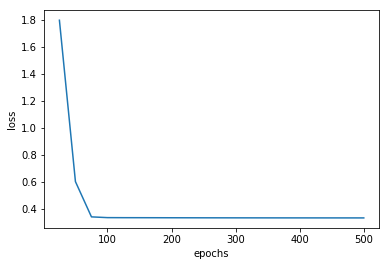

In [63]:
'''
Train listener
'''

listener = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                     decoder_layer_dims = [hidden_size,hidden_size,VOCABULARY_SIZE], decoder_activation_fn = torch.tanh, 
                     goal_input_size = 0,
                     lstm_layers=1, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

params = list(listener.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)

vocab = generate_random_vocabulary()


n_epochs = 500

corrects, incorrects = eval_listener(vocab, listener)
print(f"(Before) Acurracy: {len(corrects)/len(vocab)}")

graph_plots = train_listener(vocab, listener, optimizer, batch_size, n_epochs)

corrects, incorrects = eval_listener(vocab, listener)
print(f"(After) Acurracy: {len(corrects)/len(vocab)}")

#plotting graphs
x = []
y = []
for epoch, loss in graph_plots:
  x.append(epoch)
  y.append(loss)

plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Run (Joint training)

Ent regularization: 0.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 25, acc: 0.093, avg nll loss: 2.3148, avg ent: 1.6086, avg utterance length: 3.768
	accuracy (Total): 0.093, (Indi): dict_values([0.06, 0.12, 0.06, 0.03, 0.11, 0.14, 0.09, 0.09, 0.09, 0.14])

Epoch 50, acc: 0.088, avg nll loss: 2.3104, avg ent: 1.6066, avg utterance length: 3.328
	accuracy (Total): 0.088, (Indi): dict_values([0.11, 0.06, 0.07, 0.14, 0.06, 0.06, 0.12, 0.08, 0.09, 0.09])

Epoch 75, acc: 0.096, avg nll loss: 2.307, avg ent: 1.6063, avg utterance length: 3.856
	accuracy (Total): 0.096, (Indi): dict_values([0.11, 0.09, 0.08, 0.13, 0.07, 0.06, 0.14, 0.07, 0.07, 0.14])

Epoch 100, acc: 0.083, avg nll loss: 2.3117, avg ent: 1.5921, avg utterance length: 3.248
	accuracy (Total): 0.083, (Indi): dict_values([0.11, 0.08, 0.05, 0.08, 0.08, 0.12, 0.06, 0.03, 0.11, 0.11])

Epoch 125, acc: 0.08, avg nll loss: 2.3031, avg ent: 1.3653, avg utterance length: 4.008
	accuracy (Total): 0.08, (Indi): dict_values([0.07, 0.11, 0.12, 0.07, 0.12, 0.08, 0.07, 0.07, 0.06, 0.03])

Epoch 150, 

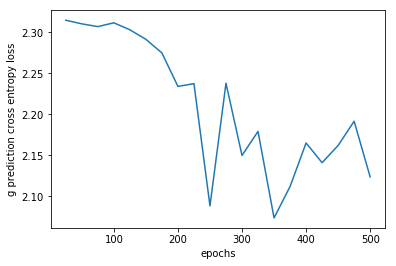

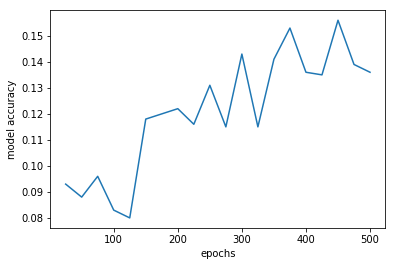

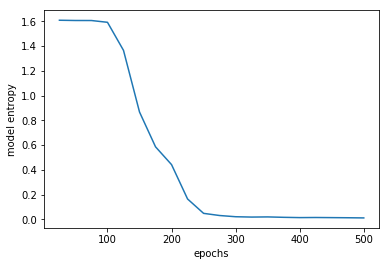

Ent regularization: 0.01
Epoch 25, acc: 0.111, avg nll loss: 2.3112, avg ent: 1.6092, avg utterance length: 4.8
	accuracy (Total): 0.111, (Indi): dict_values([0.19, 0.09, 0.17, 0.09, 0.07, 0.08, 0.12, 0.06, 0.06, 0.18])

Epoch 50, acc: 0.119, avg nll loss: 2.3022, avg ent: 1.609, avg utterance length: 4.456
	accuracy (Total): 0.119, (Indi): dict_values([0.16, 0.11, 0.2, 0.14, 0.05, 0.11, 0.12, 0.1, 0.12, 0.08])

Epoch 75, acc: 0.087, avg nll loss: 2.318, avg ent: 1.6083, avg utterance length: 3.84
	accuracy (Total): 0.087, (Indi): dict_values([0.1, 0.15, 0.04, 0.14, 0.06, 0.07, 0.1, 0.09, 0.09, 0.03])

Epoch 100, acc: 0.101, avg nll loss: 2.3102, avg ent: 1.6048, avg utterance length: 3.368
	accuracy (Total): 0.101, (Indi): dict_values([0.13, 0.1, 0.06, 0.08, 0.14, 0.1, 0.08, 0.13, 0.11, 0.08])

Epoch 125, acc: 0.108, avg nll loss: 2.3103, avg ent: 1.6, avg utterance length: 3.848
	accuracy (Total): 0.108, (Indi): dict_values([0.07, 0.13, 0.12, 0.05, 0.1, 0.1, 0.14, 0.1, 0.1, 0.17])

E

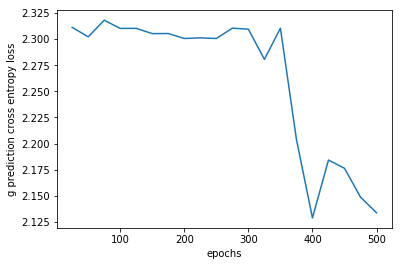

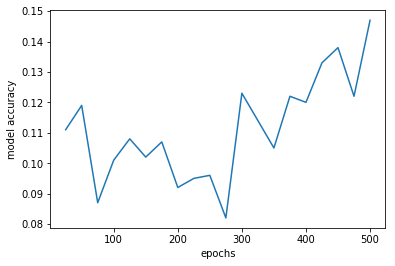

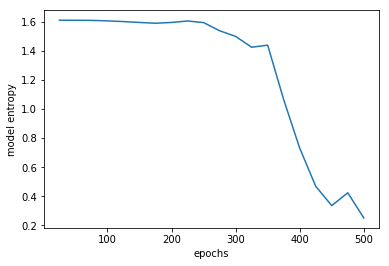

In [68]:
'''
Train jointly
'''

ent_reg_values = [0.0,0.01]
for ent_r in ent_reg_values:
  print(f"Ent regularization: {ent_r}")
  speaker = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                       decoder_layer_dims = [hidden_size,hidden_size,PHONEME_INVENTORY_SIZE], decoder_activation_fn = torch.tanh, 
                       goal_input_size = goal_size,
                       lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

  listener = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                       decoder_layer_dims = [hidden_size,hidden_size,VOCABULARY_SIZE], decoder_activation_fn = torch.tanh, 
                       goal_input_size = 0,
                       lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

  params = list(speaker.parameters()) + list(listener.parameters())
  optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)

  #train joint
  import time
  n_epochs = 500
  meanings = list(range(VOCABULARY_SIZE))

  start_time = time.time()
  graph_plots = train_joint(meanings, speaker, listener, optimizer, batch_size = 5, num_epochs = n_epochs, ent_reg_value = ent_r, ent_regularization = True)
  end_time = time.time()

  print(f"{n_epochs} epochs in {end_time-start_time} seconds")
  print()
  
  acc = eval_exp(meanings,speaker,listener, n_trials = 100).values()
  acc_num = round(sum(acc)/len(acc),4)
  print(f"\tAFTER Accuracy (Total): {acc_num}, (Indi): {acc}\n")
  
  #plotting graphs
  x = []
  y = []
  y2 = []
  y3 = []
  for epoch, acc, loss, ent in graph_plots:
    x.append(epoch)
    y.append(loss)
    y2.append(acc)
    y3.append(ent)

  plt.plot(x,y)
  plt.xlabel('epochs')
  plt.ylabel('g prediction cross entropy loss')
  plt.show()

  plt.plot(x,y2)
  plt.xlabel('epochs')
  plt.ylabel('model accuracy')
  plt.show()
  
  plt.plot(x,y3)
  plt.xlabel('epochs')
  plt.ylabel('model entropy')
  plt.show()

Ent regularization: 0.01


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


	accuracy (0.11000000000000001): dict_values([0.11, 0.09, 0.09, 0.22, 0.06, 0.13, 0.09, 0.06, 0.13, 0.12])
Epoch 25, loss: 0.5735, speaker ent: 1.6019, avg u length: 3.176
	accuracy (Total): 0.093, (Indi): dict_values([0.12, 0.06, 0.1, 0.1, 0.07, 0.08, 0.12, 0.09, 0.1, 0.09])

Epoch 50, loss: 0.4996, speaker ent: 1.5611, avg u length: 2.216
	accuracy (Total): 0.099, (Indi): dict_values([0.11, 0.1, 0.13, 0.08, 0.12, 0.07, 0.1, 0.12, 0.11, 0.05])

Epoch 75, loss: 0.3269, speaker ent: 1.4366, avg u length: 1.432
	accuracy (Total): 0.082, (Indi): dict_values([0.11, 0.11, 0.1, 0.07, 0.04, 0.05, 0.09, 0.03, 0.1, 0.12])

Epoch 100, loss: 0.3385, speaker ent: 1.4268, avg u length: 1.104
	accuracy (Total): 0.121, (Indi): dict_values([0.11, 0.12, 0.11, 0.16, 0.12, 0.12, 0.07, 0.1, 0.12, 0.18])

Epoch 125, loss: 0.3534, speaker ent: 1.4155, avg u length: 1.352
	accuracy (Total): 0.102, (Indi): dict_values([0.07, 0.1, 0.06, 0.08, 0.09, 0.14, 0.12, 0.09, 0.16, 0.11])

Epoch 150, loss: 0.1937, speak

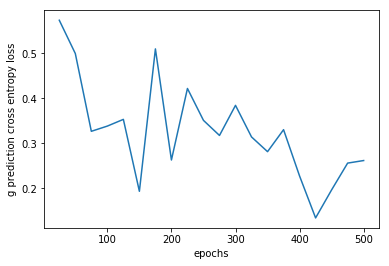

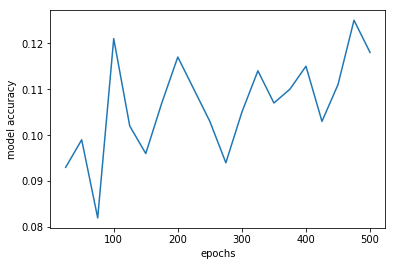

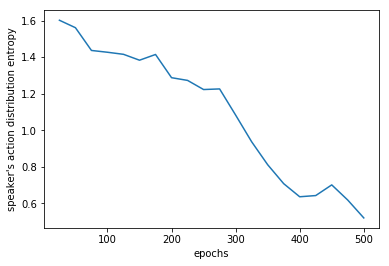

In [69]:
'''
Train jointly w/ RL
'''
ent_reg_values = [0.01]
for ent_r in ent_reg_values:
  print(f"Ent regularization: {ent_r}")
  speaker = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                       decoder_layer_dims = [hidden_size,hidden_size,PHONEME_INVENTORY_SIZE], decoder_activation_fn = torch.tanh, 
                       goal_input_size = goal_size,
                       lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

  listener = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                       decoder_layer_dims = [hidden_size,hidden_size,VOCABULARY_SIZE], decoder_activation_fn = torch.tanh, 
                       goal_input_size = 0,
                       lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

  params = list(speaker.parameters()) + list(listener.parameters())
  optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)

  #train joint
  import time
  n_epochs = 500
  meanings = list(range(VOCABULARY_SIZE))
  
  start_time = time.time()
  graph_plots = train_joint_rl(meanings, speaker, listener, optimizer, batch_size = 5, num_epochs = n_epochs, ent_reg_value = ent_r)
  end_time = time.time()
  print(f"{n_epochs} epochs in {end_time-start_time} seconds")
  print()
  
  acc = eval_exp(meanings,speaker,listener, n_trials = 100).values()
  acc_num = round(sum(acc)/len(acc),4)
  print(f"\tAFTER Accuracy (Total): {acc_num}, (Indi): {acc}\n")
  
  #plotting graphs
  x = []
  y = []
  y2 = []
  y3 = []
  for epoch, acc, loss, ent in graph_plots:
    x.append(epoch)
    y.append(loss)
    y2.append(acc)
    y3.append(ent)

  plt.plot(x,y)
  plt.xlabel('epochs')
  plt.ylabel('g prediction cross entropy loss')
  plt.show()

  plt.plot(x,y2)
  plt.xlabel('epochs')
  plt.ylabel('model accuracy')
  plt.show()
  
  plt.plot(x,y3)
  plt.xlabel('epochs')
  plt.ylabel('speaker\'s action distribution entropy')
  plt.show()


### Eval learning

In [0]:
def eval_learning(meanings, speaker, listener, n_epochs, opt):
  #fix a particular meaning
  g = meanings[0]
  g_1h = one_hot([g], len(meanings))
  
  #sample utterance from speaker
  utterance, ent = agent_generate_utterance(g_1h, speaker, include_sentinel = True)
  
  p_u = []
  p_g = []
  
  for e in range(n_epochs):
    #p(u) from speaker
    p_u.append(agent_seq_prob(g_1h, utterance, speaker))

    #p(g) from listener
    g_distro = listener(utterance[:-1])
    p_g.append(g_distro[0][g])

    #loss
    nll = -torch.log(g_distro)[0][g]
    ent = 0.01*ent
    loss = nll - ent

    #train step
    loss.backward(retain_graph = True)
    opt.step()
    opt.zero_grad()
    
    print(f"Epoch:{e}, loss:{loss.item()}, p_u:{p_u[-1]}, p_g:{p_g[-1]}")
    
    
def eval_learning_rl(meanings, speaker, listener, n_epochs, opt):
  #fix a particular meaning
  g = meanings[0]
  g_1h = one_hot([g], len(meanings))
  
  #sample utterance from speaker
  with torch.no_grad():
    utterance, _ = agent_generate_utterance(g_1h, speaker, use_gumbel_softmax = False, include_sentinel = True)
  
  p_u = []
  p_g = []
  
  for e in range(n_epochs):
    #p(u) from speaker
    p_u.append(agent_seq_prob(g_1h, utterance, speaker))
    
    
    #p(g) from listener
    g_distro = listener(utterance[:-1])
    sampled_g = torch.distributions.Categorical(g_distro).sample().squeeze(0)
    p_g.append(g_distro[0][g])
    
    
    #[2] define reward
    reward = 1 if sampled_g == g else 0

    #[3] loss
    speaker_l, ent = speaker_loss(g_1h, utterance, speaker)
    listener_l = listener_loss(utterance[:-1], g, listener)
    loss = ((speaker_l + listener_l) * reward) - (0.01*ent)
      
    #[4] backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    print(f"Epoch:{e}, loss:{loss.item()}, p_u:{p_u[-1]}, p_g:{p_g[-1]}")

In [71]:
speaker = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                       decoder_layer_dims = [hidden_size,hidden_size,PHONEME_INVENTORY_SIZE], decoder_activation_fn = torch.tanh, 
                       goal_input_size = goal_size,
                       lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

listener = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                     decoder_layer_dims = [hidden_size,hidden_size,VOCABULARY_SIZE], decoder_activation_fn = torch.tanh, 
                     goal_input_size = 0,
                     lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

params = list(speaker.parameters()) + list(listener.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)

meanings = list(range(VOCABULARY_SIZE))

eval_learning(meanings,speaker,listener, 10, optimizer)

'''
Epoch:0, loss:2.362318515777588, p_u:1.1651386557787191e-05, p_g:0.09269794821739197
Epoch:1, loss:2.2818634510040283, p_u:1.0970183211611584e-05, p_g:0.10207735747098923
Epoch:2, loss:2.183797597885132, p_u:1.0463501894264482e-05, p_g:0.11261286586523056
Epoch:3, loss:2.076338768005371, p_u:1.026092650135979e-05, p_g:0.12538844347000122
Epoch:4, loss:1.952165961265564, p_u:1.0314501196262427e-05, p_g:0.14196623861789703
Epoch:5, loss:1.803063154220581, p_u:1.0530435247346759e-05, p_g:0.16479332745075226
Epoch:6, loss:1.6203720569610596, p_u:1.0838802154466975e-05, p_g:0.197825089097023
Epoch:7, loss:1.3961049318313599, p_u:1.1195383194717579e-05, p_g:0.2475593537092209
Epoch:8, loss:1.1260018348693848, p_u:1.1576707947824616e-05, p_g:0.32432737946510315
Epoch:9, loss:0.8167701959609985, p_u:1.1968471881118603e-05, p_g:0.4418564736843109
'''

Epoch:0, loss:2.2775824069976807, p_u:0.043640464544296265, p_g:0.10089568048715591
Epoch:1, loss:2.235037088394165, p_u:0.04249417781829834, p_g:0.10697095096111298
Epoch:2, loss:2.1758222579956055, p_u:0.04267901927232742, p_g:0.11351459473371506
Epoch:3, loss:2.1137681007385254, p_u:0.043179530650377274, p_g:0.12078198045492172
Epoch:4, loss:2.047635555267334, p_u:0.04381629452109337, p_g:0.12903964519500732
Epoch:5, loss:1.9761428833007812, p_u:0.044530950486660004, p_g:0.1386028230190277
Epoch:6, loss:1.8980374336242676, p_u:0.0452987477183342, p_g:0.14986245334148407
Epoch:7, loss:1.8121567964553833, p_u:0.046108588576316833, p_g:0.16330154240131378
Epoch:8, loss:1.717474341392517, p_u:0.046956419944763184, p_g:0.17951898276805878
Epoch:9, loss:1.613152027130127, p_u:0.04783741757273674, p_g:0.19925855100154877


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


'\nEpoch:0, loss:2.362318515777588, p_u:1.1651386557787191e-05, p_g:0.09269794821739197\nEpoch:1, loss:2.2818634510040283, p_u:1.0970183211611584e-05, p_g:0.10207735747098923\nEpoch:2, loss:2.183797597885132, p_u:1.0463501894264482e-05, p_g:0.11261286586523056\nEpoch:3, loss:2.076338768005371, p_u:1.026092650135979e-05, p_g:0.12538844347000122\nEpoch:4, loss:1.952165961265564, p_u:1.0314501196262427e-05, p_g:0.14196623861789703\nEpoch:5, loss:1.803063154220581, p_u:1.0530435247346759e-05, p_g:0.16479332745075226\nEpoch:6, loss:1.6203720569610596, p_u:1.0838802154466975e-05, p_g:0.197825089097023\nEpoch:7, loss:1.3961049318313599, p_u:1.1195383194717579e-05, p_g:0.2475593537092209\nEpoch:8, loss:1.1260018348693848, p_u:1.1576707947824616e-05, p_g:0.32432737946510315\nEpoch:9, loss:0.8167701959609985, p_u:1.1968471881118603e-05, p_g:0.4418564736843109\n'

In [72]:
speaker = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                       decoder_layer_dims = [hidden_size,hidden_size,PHONEME_INVENTORY_SIZE], decoder_activation_fn = torch.tanh, 
                       goal_input_size = goal_size,
                       lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

listener = AttentionRNN(lstm_input_size = input_size, embed_size = embed_size, hidden_size = hidden_size,
                     decoder_layer_dims = [hidden_size,hidden_size,VOCABULARY_SIZE], decoder_activation_fn = torch.tanh, 
                     goal_input_size = 0,
                     lstm_layers=n_layers, lstm_dropout=dropout, lstm_bidirectional = True).to(device)

params = list(speaker.parameters()) + list(listener.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate, weight_decay = .0001)

meanings = list(range(VOCABULARY_SIZE))

eval_learning_rl(meanings,speaker,listener, 10, optimizer)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch:0, loss:3.9476776123046875, p_u:0.03770046681165695, p_g:0.09781086444854736
Epoch:1, loss:-0.016082745045423508, p_u:0.040788497775793076, p_g:0.10394564270973206
Epoch:2, loss:-0.016078297048807144, p_u:0.04294958338141441, p_g:0.10826874524354935
Epoch:3, loss:-0.016072656959295273, p_u:0.044668734073638916, p_g:0.11173033714294434
Epoch:4, loss:-0.01606661081314087, p_u:0.04610664024949074, p_g:0.11464439332485199
Epoch:5, loss:-0.016060512512922287, p_u:0.047340985387563705, p_g:0.11716244369745255
Epoch:6, loss:-0.016054552048444748, p_u:0.048416998237371445, p_g:0.11937253922224045
Epoch:7, loss:-0.01604883186519146, p_u:0.04936408996582031, p_g:0.12133201211690903
Epoch:8, loss:-0.016043417155742645, p_u:0.050203002989292145, p_g:0.123081274330616
Epoch:9, loss:-0.016038333997130394, p_u:0.050949081778526306, p_g:0.12465031445026398



### Experimental records

**April 9, 12:53pm** <br>

```
PHONEME_INVENTORY_SIZE = 16 + 1
VOCABULARY_SIZE = 48
MAX_WORD_LENGTH = 4
hidden_size = 256
n_layers = 1 #EncoderLSTM
dropout = 0.1
learning_rate = 1e-3

batch_size = 20 #training

train_speaker(vocab, speaker, optimizer, batch_size, n_epochs):
            epoch 1: loss 6.226044654846191
            epoch 101: loss 3.105109691619873
            epoch 201: loss 0.7488048672676086
            epoch 301: loss 0.2487674057483673
            epoch 401: loss 0.08418204635381699
            epoch 501: loss 0.056233298033475876
            epoch 601: loss 0.03831745311617851
            epoch 701: loss 0.0295582115650177
            epoch 801: loss 0.023506542667746544
            epoch 901: loss 0.020914575085043907
            epoch 1000: loss 0.016073906794190407
            
train_listener(vocab, listener, optimizer, batch_size, n_epochs):            
            epoch 1: loss 3.8655076026916504
            epoch 101: loss 0.9821683764457703
            epoch 201: loss 0.2731153070926666
            epoch 301: loss 0.25724339485168457
            epoch 401: loss 0.19223418831825256

---



---


            epoch 501: loss 0.22719207406044006
            epoch 601: loss 0.2528647780418396
            epoch 701: loss 0.18347255885601044
            epoch 801: loss 0.37539342045783997
            epoch 901: loss 0.3800446391105652
            epoch 1000: loss 0.3652879595756531

```

**April 5, 1:43pm**<br>
Training Speaker + Listener Agents Jointly via J = nll_loss(listener predicting target goal given utterance produced by speaker given target goal) - entropy(of the speaker's action distribution)  where ```ent = -a_distro * torch.log(a_distro)``` (I should double check that the code is correct: oops, i only returned the entropy for the last action)

```
PHONEME_INVENTORY_SIZE = 4 + 1 #(EOS)
VOCABULARY_SIZE = 10
BATCH_SIZE = 20
for 1k epochs
----------------------------------------------------------------------
Epoch 100, avg loss: 2.303295392394066, avg ent: 0.0032047181007219478
Epoch 200, avg loss: 2.20992678385973, avg ent: 0.001488100756961103
Epoch 300, avg loss: 2.065933733522892, avg ent: 6.462750437731302e-05
Epoch 400, avg loss: 2.081602655470371, avg ent: 3.386099650606411e-05
Epoch 500, avg loss: 2.0622193831801416, avg ent: 2.7811814254164347e-05
Epoch 600, avg loss: 2.057446404606104, avg ent: 2.621033969990094e-05
Epoch 700, avg loss: 2.0547059277892115, avg ent: 2.4886489180971692e-05
Epoch 800, avg loss: 2.061071104466915, avg ent: 2.467219452910285e-05
Epoch 900, avg loss: 2.0713415880203248, avg ent: 2.4777529778020833e-05
Epoch 1000, avg loss: 2.0587901176810264, avg ent: 2.3658165223878314e-05
1000 epochs in 587.2966227531433 seconds
```

**April 5, 12:57pm**<br>
Training Speaker + Listener Agents Jointly via J = nll_loss(listener predicting target goal given utterance produced by speaker given target goal)
```
PHONEME_INVENTORY_SIZE = 4 + 1 #(EOS)
VOCABULARY_SIZE = 10
BATCH_SIZE = 20
-----------------------------------------------------
Epoch 100, avg loss: 2.3028235718011856, avg ent: 0.0
Epoch 200, avg loss: 2.254662950158119, avg ent: 0.0
Epoch 300, avg loss: 2.1213961758613586, avg ent: 0.0
Epoch 400, avg loss: 2.076187927186489, avg ent: 0.0
Epoch 500, avg loss: 2.0771584681272506, avg ent: 0.0
Epoch 600, avg loss: 2.0777724222540854, avg ent: 0.0
Epoch 700, avg loss: 2.084217808008194, avg ent: 0.0
Epoch 800, avg loss: 2.0803809082508087, avg ent: 0.0
Epoch 900, avg loss: 2.065014652967453, avg ent: 0.0
Epoch 1000, avg loss: 2.067490001678467, avg ent: 0.0
Epoch 1100, avg loss: 2.0813374469280244, avg ent: 0.0
Epoch 1200, avg loss: 2.0867398483157156, avg ent: 0.0
Epoch 1300, avg loss: 2.089908520877361, avg ent: 0.0
Epoch 1400, avg loss: 2.057461781322956, avg ent: 0.0
Epoch 1500, avg loss: 2.0825169638991357, avg ent: 0.0
Epoch 1600, avg loss: 2.0632899644374847, avg ent: 0.0
Epoch 1700, avg loss: 2.0702262474894524, avg ent: 0.0
Epoch 1800, avg loss: 2.0885721085071562, avg ent: 0.0
Epoch 1900, avg loss: 2.061895338356495, avg ent: 0.0
Epoch 2000, avg loss: 2.082010128855705, avg ent: 0.0
Epoch 2100, avg loss: 2.077530323088169, avg ent: 0.0
Epoch 2200, avg loss: 2.084395706772804, avg ent: 0.0
Epoch 2300, avg loss: 2.0710587098002433, avg ent: 0.0
Epoch 2400, avg loss: 2.056579066336155, avg ent: 0.0
Epoch 2500, avg loss: 2.0728952572345736, avg ent: 0.0
Epoch 2600, avg loss: 2.075164333760738, avg ent: 0.0
Epoch 2700, avg loss: 2.0420171529054643, avg ent: 0.0
Epoch 2800, avg loss: 2.049694618463516, avg ent: 0.0
Epoch 2900, avg loss: 2.0751369814276694, avg ent: 0.0
Epoch 3000, avg loss: 2.0748237807750702, avg ent: 0.0
Epoch 3100, avg loss: 2.0660855191349983, avg ent: 0.0
Epoch 3200, avg loss: 2.067527336061001, avg ent: 0.0
Epoch 3300, avg loss: 2.061528675019741, avg ent: 0.0
Epoch 3400, avg loss: 2.0607283218503, avg ent: 0.0
Epoch 3500, avg loss: 2.0775918741822244, avg ent: 0.0
Epoch 3600, avg loss: 2.067844699859619, avg ent: 0.0
Epoch 3700, avg loss: 2.0744430291056632, avg ent: 0.0
Epoch 3800, avg loss: 2.0751035472750665, avg ent: 0.0
Epoch 3900, avg loss: 2.0758033413887023, avg ent: 0.0
Epoch 4000, avg loss: 2.078954189836979, avg ent: 0.0
Epoch 4100, avg loss: 2.085360106706619, avg ent: 0.0
Epoch 4200, avg loss: 2.074167816877365, avg ent: 0.0
Epoch 4300, avg loss: 2.0684577859044073, avg ent: 0.0
Epoch 4400, avg loss: 2.0627877841591835, avg ent: 0.0
Epoch 4500, avg loss: 2.0848449479937554, avg ent: 0.0
Epoch 4600, avg loss: 2.0743068467974664, avg ent: 0.0
Epoch 4700, avg loss: 2.0754642365574836, avg ent: 0.0
Epoch 4800, avg loss: 2.077644497334957, avg ent: 0.0
Epoch 4900, avg loss: 2.0728858067393303, avg ent: 0.0
Epoch 5000, avg loss: 2.046520941257477, avg ent: 0.0
5000 epochs in 2899.577383518219 seconds
```